## Import Packages

In [10]:
import os
import pandas as pd
import numpy as np
import random
import pickle
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

## Read Training Data

### Training Dataset is the same as the one which the model is trained on

In [11]:
#Bring in data used to train pickled model that is loaded in later
df = pd.read_csv('/mnt/code/Test&TrainData/ChurnTrainingDataPP.csv')
df.drop('predictionProbability', axis =1,inplace = True)
print(f" The shape of training dataset is {df.shape}")
print("""* \n* \n*""")
df.head()

 The shape of training dataset is (7939, 7)
* 
* 
*


,custid,dropperc,mins,consecmonths,income,age,churn_Y
0,844336,0.016364,550,28,89.2,45,0
1,146041,0.018349,545,33,54.2,43,0
2,847745,0.018519,378,41,55.3,41,0
3,285565,0.014493,552,32,66.8,31,0
4,754611,0.012132,577,4,87.2,43,0


## Synthesizing Data

In [17]:
#append data to istelf to double volume
df2 = df.append(df)

#Reset custid field so that there are no repeats
df2['custid'] = np.random.choice(range(df.custid.min(), df.custid.max()),df2.shape[0], replace=False)

##For each input feature adjust data and round/cast as necessary
#dropperc - 50%-150%
droppJitter = df2.dropperc.apply(lambda x : x*(random.randrange(50,150))/100)
#mins - 70%-130%
minsJitter = df2.mins.apply(lambda x : x*(random.randrange(70,130)/100)).round(0).astype(int)
#consecMonths - 80%-120%
consecMonthsJitter = df2.consecmonths.apply(lambda x : x*(random.randrange(80,120)/100)).round(0).astype(int)
#Income - 40%-160%
incomeJitter = df2.income.apply(lambda x : x*(random.randrange(40,160)/100)).round(1)
#age - 90%-110%
ageJitter = df2.age.apply(lambda x : x*(random.randrange(90,110)/100)).round(0).astype(int)

#Take all the new 'jittered' variables and write to a new df
#Keep original custid and churn_Y fields
df3 = pd.DataFrame({'custid': df2.custid,
       'dropperc': droppJitter, 
       'mins': minsJitter,
       'consecmonths': consecMonthsJitter,
       'income': incomeJitter,
       'age': ageJitter,
       'churn_Y': df2.churn_Y
                   })

#Understand correlations between new jittered data and original
#Should see larger data drift for lower correlations
concatset = pd.concat([df2,df3], axis =1)
concatset.columns=(list(df2.columns)+list('Jittered_'+df3.columns))
print('Correlations between original and altered vars -')
for i,k in enumerate(df2.columns):
    print('{}: {}'.format(k, concatset.corr()[k]['Jittered_'+k].round(4)))

Correlations between original and altered vars -
custid: 1.0
dropperc: 0.7398
mins: 0.7461
consecmonths: 0.9285
income: 0.6225
age: 0.9692
churn_Y: 1.0


In [20]:
#Grab between 100 and 500 random rows from jittered data
df_inf = df3.sample(n = random.randint(100,500))
print(df_inf.shape[0], "records selected for sample")
df_inf.head()

print(f" The shape of df_inf aka jittered training dataset is {df_inf.shape}")
print("""* \n* \n*""")
df_inf.head()

451 records selected for sample
 The shape of df_inf aka jittered training dataset is (451, 7)
* 
* 
*


,custid,dropperc,mins,consecmonths,income,age,churn_Y
392,1861,0.014773,440,43,93.7,39,0
7262,123711,0.011205,436,21,81.6,30,0
250,585151,0.017152,433,40,84.5,44,0
7311,905202,0.007089,771,16,61.8,55,0
168,547118,0.013387,835,19,106.2,44,0


## Load Model for Prediction and Probability Range

In [23]:
#Load in trained model object    
loaded_model = pickle.load(open('/mnt/code/models/ChurnBinaryClassifier.pkl', 'rb'))

#Save input features
X = df_inf.loc[:, 'dropperc':'age']
print(f"shape of X is {X.shape}")
X.head()

shape of X is (451, 5)


/opt/conda/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator AdaBoostClassifier from version 0.22.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


,dropperc,mins,consecmonths,income,age
392,0.014773,440,43,93.7,39
7262,0.011205,436,21,81.6,30
250,0.017152,433,40,84.5,44
7311,0.007089,771,16,61.8,55
168,0.013387,835,19,106.2,44


### Prediction

In [40]:
#Get model predictions for the sample of input features defined above
predictions = loaded_model.predict(X)
print(f"lenght of prediction is {len(predictions)}")

churn_groundTruth = pd.DataFrame(df_inf[['custid','churn_Y']]).rename(columns = {'churn_Y': 'y_gt'})
churn_groundTruth.head()

lenght of prediction is 451


/opt/conda/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


,custid,y_gt
392,1861,0
7262,123711,0
250,585151,0
7311,905202,0
168,547118,0


### Probability range

In [33]:
#Get model prediction probabilities for the sample of input features defined above
probas = loaded_model.predict_proba(X).tolist() # converting from array to list to be compatible for dataframe probability range
print(f"lenght of probas is {len(probas)}")
probas[:4]

lenght of probas is 451


/opt/conda/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


[[0.5389354774737906, 0.4610645225262094],
 [0.7272066909703132, 0.2727933090296868],
 [0.5530625393592452, 0.44693746064075474],
 [0.9174214845766199, 0.08257851542338024]]

In [34]:
#Create data set with predictions and pred probabilities
preds_df = pd.DataFrame(data=predictions, columns=['churn_Y'], index=churn_groundTruth.index)
preds_df['predictionProbability']= tuple(probas)
preds_df

,churn_Y,predictionProbability
392,0,"[0.5389354774737906, 0.4610645225262094]"
7262,0,"[0.7272066909703132, 0.2727933090296868]"
250,0,"[0.5530625393592452, 0.44693746064075474]"
7311,0,"[0.9174214845766199, 0.08257851542338024]"
168,0,"[0.8372671458551001, 0.16273285414490002]"
...,...,...
724,0,"[0.5668381145473016, 0.4331618854526985]"
6358,0,"[0.544183067082906, 0.4558169329170941]"
1000,0,"[0.5317591472126512, 0.4682408527873489]"
2683,1,"[0.4798060277388084, 0.5201939722611915]"


In [35]:
df_inf.head()

,custid,dropperc,mins,consecmonths,income,age,churn_Y
392,1861,0.014773,440,43,93.7,39,0
7262,123711,0.011205,436,21,81.6,30,0
250,585151,0.017152,433,40,84.5,44,0
7311,905202,0.007089,771,16,61.8,55,0
168,547118,0.013387,835,19,106.2,44,0


In [36]:
#join prediction and prob data with input features dropping churn_Y
churn_inputs_and_preds = df_inf.drop('churn_Y', axis =1)\
.join(preds_df, how = 'inner').drop_duplicates(subset = 'custid')

In [37]:
#Create 'protected class' feature to monitor for disparity in target distribution
churn_inputs_and_preds['Gender']=np.random.randint(0,3, churn_inputs_and_preds.shape[0])
mymap = {0:'M',1: 'F', 2: 'NB'}
churn_inputs_and_preds['Gender'] = churn_inputs_and_preds['Gender'].apply(lambda x: mymap.get(x))
churn_inputs_and_preds.head()

,custid,dropperc,mins,consecmonths,income,age,churn_Y,predictionProbability,Gender
54,931760,0.016921,751,19,44.6,38,0,"[0.7515980501170508, 0.2484019498829492]",NB
72,202238,0.013333,429,29,36.9,41,0,"[0.7125475564312976, 0.28745244356870225]",F
99,687369,0.014273,527,33,62.2,46,0,"[0.5490261166824935, 0.45097388331750654]",NB
114,10359,0.005993,643,22,48.0,48,0,"[0.7353684230639908, 0.2646315769360092]",F
129,156299,0.015453,490,32,103.1,44,0,"[0.5509289442929776, 0.4490710557070225]",NB


## Visualization

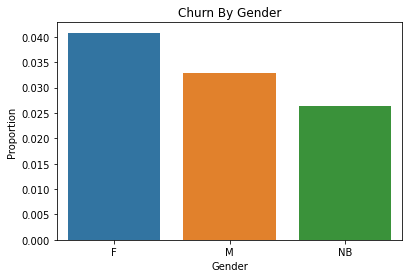

In [42]:
#Add visualization of protected class for tracking purposes
ax = sns.barplot(x = ['F', 'M', 'NB'], y = churn_inputs_and_preds.groupby('Gender').mean()['churn_Y'])

ax.set_title('Churn By Gender')
ax.set_ylabel('Proportion')
ax.set_xlabel('Gender')
fig = ax.get_figure()
fig.set_size_inches(12,4)
plt.gcf().subplots_adjust(left=0.5)

#fig.savefig('/mnt/code/Viz/protected_class_monitoring.png')

## Checks for Writing Data

In [43]:
## Run two checks below to validate input and GT data is of same size and contains same custIDs

lenCheck = churn_inputs_and_preds.shape[0]==churn_groundTruth.shape[0]
print('Length Check Pass:', lenCheck)

idCheck= (churn_inputs_and_preds.custid.sort_values()==churn_groundTruth.custid.sort_values())\
.sum() ==churn_inputs_and_preds.shape[0]
print('ID Check Pass:', idCheck)

Length Check Pass: True
ID Check Pass: True


In [44]:
churn_inputs_and_preds.shape

(451, 9)

In [45]:
churn_groundTruth.shape

(451, 2)

## Saving Prediction and GT data locally to DailyData directory

In [29]:
# Write input and pred data to DailyData folder # ---> this is the ground truth
daily_data_path = '/mnt/code/DailyData/'
input_and_pred_path = str(daily_data_path+'inputs_and_preds_'+str(datetime.date.today())+'.csv')
ground_truth_path = str(daily_data_path+'ground_truth_'+str(datetime.date.today())+'.csv')

# saving Prediction data to csv
churn_inputs_and_preds.to_csv(input_and_pred_path, index = False)

# saving Ground Truth data to csv
churn_groundTruth.to_csv(ground_truth_path, index = False)

## Upload the Prediction data and Ground Truth to S3 bucket

In [ ]:
import certs
bucket = certs.bucket

In [31]:
import upload_to_s3
#Upload input&pred data and GT data to s3 bucket 
upload_to_s3.upload(input_and_pred_path, bucket)
upload_to_s3.upload(ground_truth_path, bucket)

inputs_and_preds_2022-05-05.csv Upload Successful
ground_truth_2022-05-05.csv Upload Successful


True

## Manual Prediction and GT DMM registration

At the end of the above stage there must be at least 5 files in your Amazon S3 bucket

### 1. Register the model using the following format

### 2. Register the Prediction data

### 3. Register the Ground Truth data * initial registration*

## At this point we are done with s3

In [ ]:
import requests

In [34]:
#dmm_api_key = os.environ.get('DMM_API_TOKEN')
#dmm_api_key = certs.dmm_api_key

#print(dmm_api_key)

In [ ]:
#model_id = '<dmm-model-id>'
model_id = certs.model_id

In [ ]:
#Define file names for payload construction below
inputs_file_name = str('inputs_and_preds_'+str(datetime.date.today())+'.csv')
ground_truth_file_name = str('ground_truth_'+str(datetime.date.today())+'.csv')

In [ ]:
#Define api endpoint # Adding dmm model ID
inputs_url = "https://demo.dominodatalab.com/model-monitor/v2/api/model/{}/register-dataset/prediction".format(model_id)

In [ ]:
inputs_file_name

In [ ]:
#Create inputs and prediction data payload
inputs_payload = """
{{
"datasetDetails": {{
        "name": "{0}",
        "datasetType": "file",
        "datasetConfig": {{
            "path": "{0}",
            "fileFormat": "csv"
        }},
        "datasourceName": "churn-dmm-46",
        "datasourceType": "s3"
    }}
}}
""".format(inputs_file_name)

In [ ]:
#Set up call headers  # Adding dmm_api_key
headers = {
           'X-DMM-API-KEY': dmm_api_key,
           'Content-Type': 'application/json'
          }

In [ ]:
#Make API call # importing requests
inputs_response = requests.request("PUT", inputs_url, headers=headers, data = inputs_payload)

In [ ]:
#create GT payload    
ground_truth_payload = """
{{

"datasetDetails": {{
        "name": "{0}",
        "datasetType": "file",
        "datasetConfig": {{
            "path": "{0}",
            "fileFormat": "csv"
        }},
        "datasourceName": "churn-dmm-46",
        "datasourceType": "s3"
    }}
}}
""".format(ground_truth_file_name)

In [ ]:
#Define api endpoint
ground_truth_url = "https://demo.dominodatalab.com/model-monitor/v2/api/model/{}/register-dataset/ground_truth".format(model_id)

In [ ]:
#Make api call
ground_truth_response = requests.request("PUT", ground_truth_url, headers=headers, data = ground_truth_payload)

In [ ]:
#Print response
print(ground_truth_response.text.encode('utf8'))